# First_fit does a first-order 2-point correlation function fit to find the effective nucleon mass for the 0.09 fm a09m310_e_gA_srcs0-15.h5 data set

In [11]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import gvar as gv

In [12]:
import h5py
import lsqfit

In [13]:
# Constants

#Physical constants
hbarc = 197.3 # MeV fm
#a = 0.09

# Pion mass
mpi = 0.1407

# Plot constants
t_min_plt = 1
t_max_plt = 25

In [14]:
# Get the data
file = h5py.File("a09m310_e_gA_srcs0-15.h5", "r")
# First, work to replicate Jinchen's results
data_proton_dn = np.array(file['gf1p0_w3p5_n45_M51p1_L56_a1p5']['spec']['ml0p00951']['proton']['px0_py0_pz0']['spin_dn'])
data_proton_up = np.array(file['gf1p0_w3p5_n45_M51p1_L56_a1p5']['spec']['ml0p00951']['proton']['px0_py0_pz0']['spin_up'])
data_np_proton_dn = np.array(file['gf1p0_w3p5_n45_M51p1_L56_a1p5']['spec']['ml0p00951']['proton_np']['px0_py0_pz0']['spin_dn'])
data_np_proton_up = np.array(file['gf1p0_w3p5_n45_M51p1_L56_a1p5']['spec']['ml0p00951']['proton_np']['px0_py0_pz0']['spin_up'])



In [15]:
def En(n, p):
    En = p['E0']
    for i in range(n):
        En += p['dE{}'.format(i)]
        
    #print(En)    
    return En

In [16]:
num_zs = 1 #Order number of the n's
# Log E: log of the energy.  
# P is point (in the context of )

# Define the 2-point fit function, for P-S and P-P
def C_2pt(t, p):
    
    z = np.array([])
    ztilde = np.array([])
    E = np.array([])
    for i in range(num_zs):
        z = np.append(z, p['Z{}'.format(i)])
        ztilde = np.append(ztilde, p['Ztilde{}'.format(i)])
        E = np.append(E, En(i, p))
        
    
    sum_pp = sum([z[i]*z[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    sum_ps = sum([z[i]*ztilde[i]*np.exp(-E[i]*t) for i in range(num_zs)])
    
    return np.transpose(np.array([[sum_pp], [sum_ps]]), axes=[2,0,1])

In [17]:
# Set up the data set, average over the spin up, spin down, negative and positive parity proton, over all 1054 points
protons = (data_proton_dn + data_proton_up + data_np_proton_dn + data_np_proton_up)/4.
proton_timeavg = gv.dataset.avg_data(protons)

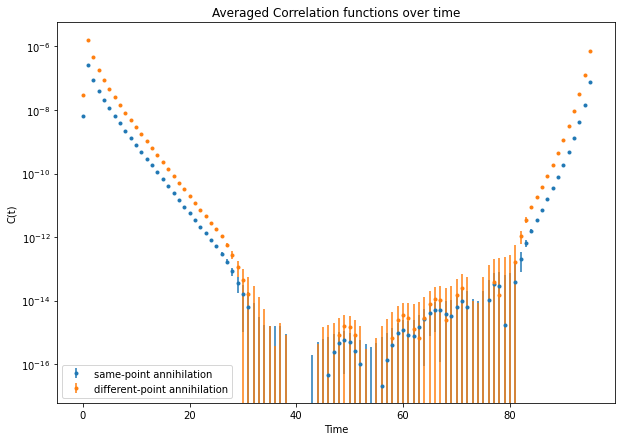

In [18]:
# Plot Correlation functions
fig = plt.figure(figsize=(10,7))
ax = plt.axes()
ax.semilogy()
ax.errorbar([i for i in range(len(proton_timeavg))], [proton_timeavg[i][0][0].mean for i in range(len(proton_timeavg))], yerr=[proton_timeavg[i][0][0].sdev for i in range(len(proton_timeavg))], fmt='.', label="same-point annihilation")
ax.errorbar([i for i in range(len(proton_timeavg))], [proton_timeavg[i][1][0].mean for i in range(len(proton_timeavg))], yerr=[proton_timeavg[i][1][0].sdev for i in range(len(proton_timeavg))], fmt='.', label="different-point annihilation")

plt.xlabel("Time")
plt.ylabel("C(t)")
plt.title("Averaged Correlation functions over time")
plt.legend()
plt.show()

In [19]:
tau = 1
# Effective mass data (same annihilation, different annihilation)
eff_mass = [[np.log(proton_timeavg[t][0][0]/proton_timeavg[t+tau][0][0])/tau for t in range(len(proton_timeavg)-tau)],\
            [np.log(proton_timeavg[t][1][0]/proton_timeavg[t+tau][1][0])/tau for t in range(len(proton_timeavg)-tau)]]
log_eff_mass = np.log(eff_mass)

<ipython-input-19-0aa53cc0f47d>:3: RuntimeWarning: invalid value encountered in log
  eff_mass = [[np.log(proton_timeavg[t][0][0]/proton_timeavg[t+tau][0][0])/tau for t in range(len(proton_timeavg)-tau)],\
<ipython-input-19-0aa53cc0f47d>:4: RuntimeWarning: invalid value encountered in log
  [np.log(proton_timeavg[t][1][0]/proton_timeavg[t+tau][1][0])/tau for t in range(len(proton_timeavg)-tau)]]
<ipython-input-19-0aa53cc0f47d>:5: RuntimeWarning: invalid value encountered in log
  log_eff_mass = np.log(eff_mass)


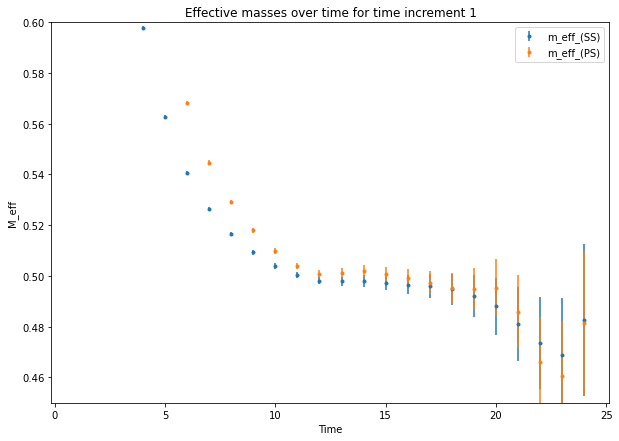

In [20]:
# Plot the effective masses
fig = plt.figure(figsize=(10,7))
ax = plt.axes()
ax.errorbar(np.array([i for i in range(t_min_plt,t_max_plt)]), np.array([eff_mass[0][i].mean for i in range(t_min_plt,t_max_plt)]), yerr=np.array([eff_mass[0][i].sdev for i in range(t_min_plt,t_max_plt)]), fmt='.', label="m_eff_(SS)")
ax.errorbar(np.array([i for i in range(t_min_plt,t_max_plt)]), np.array([eff_mass[1][i].mean for i in range(t_min_plt,t_max_plt)]), yerr=np.array([eff_mass[1][i].sdev for i in range(t_min_plt,t_max_plt)]), fmt='.', label="m_eff_(PS)")

plt.xlabel("Time")
plt.ylabel("M_eff")
plt.ylim(0.45, 0.6)
#plt.yticks(np.arange(0.6,0.8, 0.02))
plt.title("Effective masses over time for time increment {}".format(tau))
plt.legend()
plt.show()
fig.savefig("meff_rawdata.png")


<ipython-input-21-46c8ec14e1a5>:2: RuntimeWarning: invalid value encountered in sqrt
  zS_eff = np.array([np.sqrt(np.exp(eff_mass[0][t]*t)*proton_timeavg[t][0][0]) for t in range(len(proton_timeavg)-tau)])
No handles with labels found to put in legend.


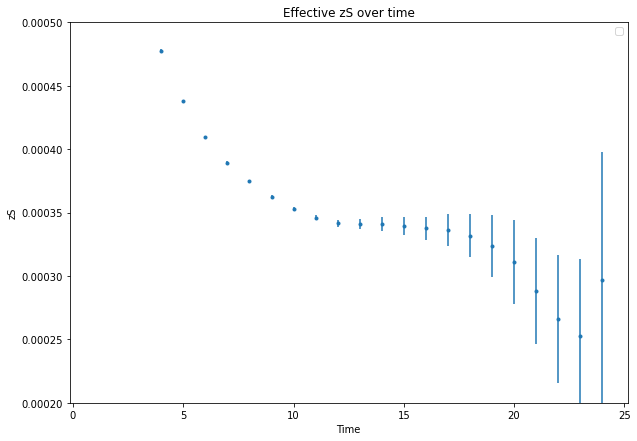

In [21]:
# Plot effective zS
zS_eff = np.array([np.sqrt(np.exp(eff_mass[0][t]*t)*proton_timeavg[t][0][0]) for t in range(len(proton_timeavg)-tau)])


fig = plt.figure(figsize=(10,7))
ax = plt.axes()
ax.errorbar(np.array([i for i in range(t_min_plt,t_max_plt)]), np.array([zS_eff[i].mean for i in range(t_min_plt,t_max_plt)]), np.array([zS_eff[i].sdev for i in range(t_min_plt,t_max_plt)]), fmt='.')

plt.xlabel("Time")
plt.ylabel("zS")
plt.title("Effective zS over time")
plt.ylim(0.0002, 0.0005)
plt.legend()
plt.show()

fig.savefig("ZSeff_rawdata.png")

No handles with labels found to put in legend.


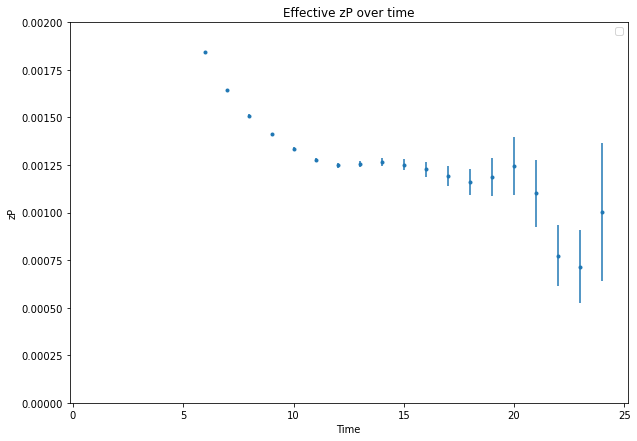

In [22]:
zP_eff = np.array([np.exp(eff_mass[1][t]*t)*proton_timeavg[t][1][0]/zS_eff[t] for t in range(len(proton_timeavg)-tau)])

fig = plt.figure(figsize=(10,7))
ax = plt.axes()
ax.errorbar(np.array([i for i in range(t_min_plt,t_max_plt)]), np.array([zP_eff[i].mean for i in range(t_min_plt,t_max_plt)]), np.array([zP_eff[i].sdev for i in range(t_min_plt,t_max_plt)]), fmt='.')

plt.xlabel("Time")
plt.ylabel("zP")
plt.title("Effective zP over time")
plt.ylim(0, 0.002)
plt.legend()
plt.show()

fig.savefig("ZPeff_rawdata.png")

In [23]:
# Make an qualitative estimate of the priors
p=gv.BufferDict()
p['E0'] = gv.gvar(0.50, 0.02)
p['Z0'] = gv.gvar(0.00033, 0.00003)
p['Ztilde0'] = gv.gvar(0.0012, 0.0002)

In [24]:
# First-order fit for tsep = 8 to 12 (approximately linear region)
num_zs = 1
fit1 = lsqfit.nonlinear_fit(data=(np.array([i for i in range(16, 20)]), np.array([proton_timeavg[i] for i in range(16, 20)])), prior=p,fcn=C_2pt,debug=True)
print(fit1.format(pstyle='vv'))

Least Square Fit:
  chi2/dof [dof] = 0.59 [8]    Q = 0.79    logGBF = 221.6

Parameters:
             E0       0.497748 +- 0.00314524             [      0.5 +- 0.02 ]  
             Z0   0.000340967 +- 7.80976e-06             [ 0.00033 +- 3e-05 ]  
        Ztilde0    0.00119037 +- 2.80267e-05             [ 0.0012 +- 0.0002 ]  

Settings:
  svdcut/n = 1e-12/0    tol = (1e-08*,1e-10,1e-10)    (itns/time = 6/0.0)
  fitter = scipy_least_squares    method = trf

